# Trace detection using reinforcement learning:
In this project, we treat drawing traces as a game:
1. State: the immediate neighbor 8 pixels + convoluted surrounding
2. action: 4 directions to go
3. reward/punishment:
    * $R(s, a, s')$: if s' is not marked: -4
    * $R(s, a, s')$: if s' is marked +1
4. end of game: when a previously marked pixel is marked

Starting pixel is selected randomly from the marked image.

In [1]:
import tensorflow as tf
from tensorflow.contrib.layers import convolution2d, fully_connected
import numpy.random as rnd
import numpy as np
from utility import *
from Env import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
import cv2
%load_ext autoreload
%autoreload 2
%pylab inline

/home/bzr0014/anaconda3/envs/tensorGpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/anaconda3/envs/tensorGpu/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sign', 'colors', 'log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
input_shape = (44, 44)
unmarked_image = cv2.imread('/home/bzr0014/git/sesek2/test_single.jpg')
marked_image = cv2.imread('/home/bzr0014/git/sesek2/test_single_marked.jpg', 0)
env = TraceEnv(unmarked_image, marked_image, input_shape)

Number of rows and columns: 1, 2


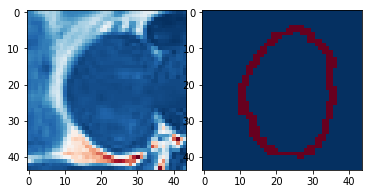

(44, 44, 1)


In [3]:
showImages([env.img[:, :, 0], env.mark])
print(env.img.shape)

### Convolutional layer formula: $(W−F+2P)/S+1$

In [4]:
learning_rate = 1e-3
input_height, input_width = input_shape
input_channels = 1
conv_n_maps = [16, 32, 32]
conv_kernel_sizes = [(4,4), (2,2), (2,2)]
conv_strides = [2, 2, 1]
conv_paddings = ["SAME"]*3
conv_activation = [tf.nn.relu]*3

n_hidden_in = 32 * 11 * 11 # conv3 has 64 maps of 11x10 each
n_hidden = 256
hidden_activation = tf.nn.relu

n_outputs = env.action_space.n # 4 discrete actions are available
initializer = tf.contrib.layers.variance_scaling_initializer()

In [5]:
def q_network(X_state, scope):
    prev_layer = X_state
    conv_layers = []
    with tf.variable_scope(scope) as scope:
        for n_maps, kernel_size, stride, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = convolution2d(prev_layer, num_outputs=n_maps,\
                                       kernel_size=kernel_size, stride=stride,\
                                       padding=padding, activation_fn=activation,\
                                       weights_initializer=initializer)
            conv_layers.append(prev_layer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = fully_connected(last_conv_layer_flat, n_hidden, \
                                 activation_fn=hidden_activation, \
                                 weights_initializer=initializer)
        outputs = fully_connected(hidden, n_outputs, activation_fn=None,\
                                  weights_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [6]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
input_channels])
actor_q_values, actor_vars = q_network(X_state, scope="q_networks/actor")
critic_q_values, critic_vars = q_network(X_state, scope="q_networks/critic")
copy_ops = [actor_var.assign(critic_vars[var_name])
for var_name, actor_var in actor_vars.items()]
copy_critic_to_actor = tf.group(*copy_ops)

In [7]:
X_action = tf.placeholder(tf.int32, shape=[None])
q_value = tf.reduce_sum(critic_q_values * tf.one_hot(X_action, n_outputs),
axis=1, keep_dims=True)

In [8]:
y = tf.placeholder(tf.float32, shape=[None, 1])
cost = tf.reduce_mean(tf.square(y - q_value))
global_step = tf.Variable(0, trainable=False, name='global_step')
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cost, global_step=global_step)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [9]:
from collections import deque
replay_memory_size = 10000
replay_memory = deque([], maxlen=replay_memory_size)
def sample_memories(batch_size):
    indices = rnd.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return (cols[0], cols[1], cols[2].reshape(-1, 1),\
            cols[3], cols[4].reshape(-1, 1))

In [10]:
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 50000
def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if rnd.rand() < epsilon:
        return rnd.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [11]:
n_steps = 100000 # total number of training steps
training_start = 1000 # start training after 1,000 game iterations
training_interval = 3 # run a training step every 3 game iterations
save_steps = 50 # save the model every 50 training steps
copy_steps = 25 # copy the critic to the actor every 25 training steps
discount_rate = 0.95
skip_start = 90 # skip the start of every game (it's just waiting time)
batch_size = 50
iteration = 0 # game iterations
checkpoint_path = "./my_dqn.ckpt"
checkpoint_file = './my_dqn.ckpt.data-00000-of-00001'
#checkpoint_path = "./my_dqn.ckpt.data-00000-of-00001"
done = True # env needs to be reset

In [12]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_file):
        print("File already exists")
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        if done: # game over, start again
            state = env.reset()
        # Actor evaluates what to do
        q_values = actor_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)
        # Actor plays
        next_state, reward, done, info = env.step(action)
        # Let's memorize what just happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state
        if iteration < training_start or iteration % training_interval != 0:
            continue
        # Critic learns
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (sample_memories(batch_size))
        next_q_values = actor_q_values.eval(feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values
        training_op.run(feed_dict={X_state: X_state_val, X_action: X_action_val, y: y_val})
        # Regularly copy critic to actor
        if step % copy_steps == 0:
            copy_critic_to_actor.run()
        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)
        if step % 100 == 0:
            print("At step %d/%d"%(step, n_steps))


File already exists
INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt
-185


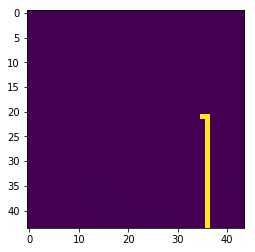

In [15]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_file):
        saver.restore(sess, checkpoint_path)
        env.reset()
        done = False
        total_reward = 0
        while not done:
            q_values = actor_q_values.eval(feed_dict={X_state: [state]})
            action = epsilon_greedy(q_values, step)
            #print(action)
            # Actor plays
            next_state, reward, done, info = env.step(action)
            total_reward += reward
    else:
        print("File not found!!")
print(total_reward)
plt.imshow(next_state[:, :, 0])

In [61]:
obs = env.reset()
for i in range(30):
    env.greedy_step()

[-1  1] [array([0.02077415]), array([0.3470348]), array([0.1693892]), array([0.03515625])] 1
[-1 -1] [array([0.37109375]), array([-0.0612571]), array([-0.41148793]), array([256.94300426])] 3
[-1  1] [array([0.33274148]), array([256.88006037]), array([-0.02716619]), array([0.12384588])] 1
[-1 -1] [array([-0.03009588]), array([-0.06170099]), array([0.]), array([256.88396662])] 3
[-1  1] [array([-0.03275923]), array([256.84881037]), array([-0.01802202]), array([-0.01935369])] 1
[-1 -1] [array([-0.015625]), array([-0.01198509]), array([-0.00266335]), array([256.86834162])] 3
[-1  1] [array([0.00150923]), array([256.87943892]), array([0.00816761]), array([0.01970881])] 1
[-1 -1] [array([0.0078125]), array([-0.01376065]), array([-0.0078125]), array([256.87615412])] 3
[-1  1] [array([-0.00301847]), array([256.86106179]), array([0.00142045]), array([-0.02654474])] 1
[-1 -1] [array([-0.04039418]), array([0.01500355]), array([0.00363991]), array([256.83158736])] 3
[-1  1] [array([0.0221946]), ar

In [65]:
m, n, c = env.img.shape
print(m, n)

44 44


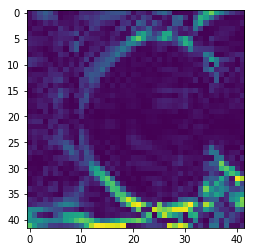

In [140]:
def to_uchar(img):
    img = img.astype('float32')
    return (img * 255).astype('uint8')
env.reset()
i1 = env.img[:m-2, :, 0]
i2 = env.img[2:m, :, 0]
i3 = env.img[:, :n-2, 0]
i4 = env.img[:, 2:n, 0]
i5 = env.img[:m-2, :n-2, 0]
i6 = env.img[2:m, 2:n, 0]
d1 = np.abs(i2-i1)[:, :42]
d2 = np.abs(i4-i3)[:42, :]
d3 = np.abs(i6 - i5)
plt.imshow(to_uchar(d1))

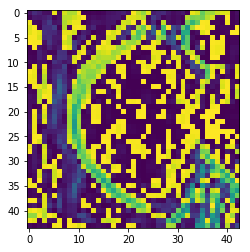

In [72]:
plt.imshow(((i4-i1)*255).astype('uint8'))